In [1]:
from gensim.models import KeyedVectors
import pickle
import pandas as pd
from datetime import datetime, date, time
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import textrank
import os
import sys
import numpy as np
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem.porter import *

stemmer = PorterStemmer()
stopwords = stopwords.words("english")
stopwords.extend(["chris", "satterfield", "cds00", "cs", "ubc", "ca"])

In [2]:
model = KeyedVectors.load("../models/normalized.model")
#nlp = spacy.load("en")

In [3]:
def valid(dateobj, start, end):
    return dateobj >= start and dateobj < end        

def tfidf(task_counters):
    idf_counters = []
    for counter in task_counters:
        n = Counter()
        for key in counter:
            n[key] = 1
        idf_counters.append(n)
    total_counter = sum(idf_counters, Counter())
    
    weighted_counters = []
    for counter in task_counters:
        occurances = []
        for key in counter.keys():
            occurances.append(total_counter[key])
        
        mean = np.mean(occurances)
        
        weighted = {}
        for key in counter.keys():
            weighted[key] = counter[key]/((total_counter[key]) * (1 + abs(mean - total_counter[key])))
        weighted_counters.append(Counter(weighted))
    return weighted_counters


In [4]:
class ScreenshotTaskExtractor(object):

    def __init__(self, vocab):
        self.vocab = vocab


    def isProbablyEmail(self, task):
        excludedWords = ['compose', 'gmail', 'inbox', 'google', 'starred', 'sent','mail','drafts','more','terms','privacy','program','policies']
        i = 0
        for word in excludedWords:
            if word in task:
                i += 1
        return i > 4

    def get_tasks_for_participant(self, path_to_data, participant, without_emails=True, ungrouped=False, filter=lambda x: word_tokenize(x), using_tfidf=False):

        with open(f"{path_to_data}/{participant}/fulltext.pkl", "rb") as f:
            snapshotsWithDates = pickle.load(f)
        
        df = pd.read_excel(f"{path_to_data}/{participant}/taskswitches_annotated.xlsx")
        offset = df[df["task"] == "offset"]["end"].iloc[0]
        df = df[df["task"] != "offset"]
        task_words_ungrouped = []
        task_order = []

        studyStartTime = snapshotsWithDates[0][0] - (datetime.combine(date.min, offset) - datetime.min)

        for _,row in df.iterrows():
            startDelta = datetime.combine(date.min, row["start"]) - datetime.min 
            endDelta = datetime.combine(date.min, row["end"]) - datetime.min
            start = studyStartTime + startDelta
            end = studyStartTime + endDelta

            snapshotsInTask = [x[1].lower() for x in snapshotsWithDates if valid(x[0], start, end)]
            
            if(without_emails):
                snapshotsInTask = [x for x in snapshotsInTask if not self.isProbablyEmail(x)]

            c = defaultdict(list)

            for snapshot in snapshotsInTask:
                tokens = word_tokenize(snapshot)
                snapshot_words = [x for x in tokens if x.isalpha()]
                snapshot_words = [x for x in snapshot_words if not x in stopwords and x in self.vocab]
                snapshot_words = [x for x in snapshot_words if len(x) > 2]
                stemmed_words = [(stemmer.stem(x), x) for x in snapshot_words]
                
                for stem, word in stemmed_words:
                    c[stem].append(word)
                
            words = []
            for stem in c:
                counter  = Counter(c[stem])
                words.extend([counter.most_common(1)[0][0]] * sum(counter.values()))

            if(len(words) > 0):
                task_words_ungrouped.append(words)
                task_order.append(row["task"])
        
        task_counters = [Counter(x) for x in task_words_ungrouped]
        if(not ungrouped):
            counters = defaultdict(Counter)
            for counter, task in zip(task_counters, task_order):
                counters[task] += counter
            task_order, task_counters = zip(*counters.items())
            
        if(using_tfidf):
            task_counters = tfidf(task_counters)

        for task in task_counters:
            norm = np.linalg.norm(list(task.values()))
            for word in task:
                task[word] = task[word]/norm

        return task_counters, task_order


In [5]:
te = ScreenshotTaskExtractor(model.wv.vocab)
path_to_data = "../../archives/"
participants = ["P01", "P02", "P03", "P04",
                "P05", "P06", "P07", "P08",
                "P11", "P12", "P13", "P14",
                "P15", "P16", "P17", "P18", "P19"]


PARTICIPANT:  P01
--------------------------



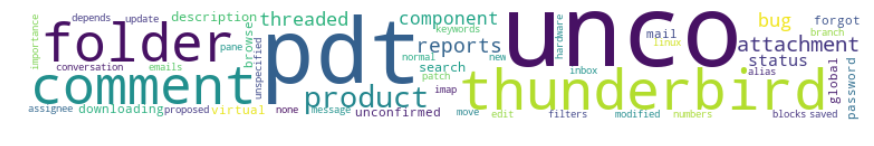

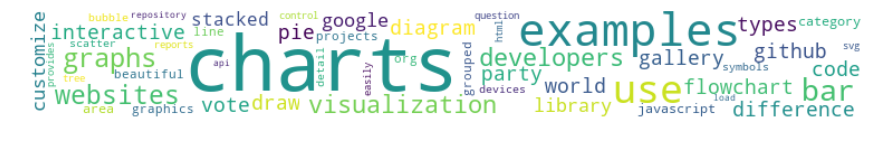

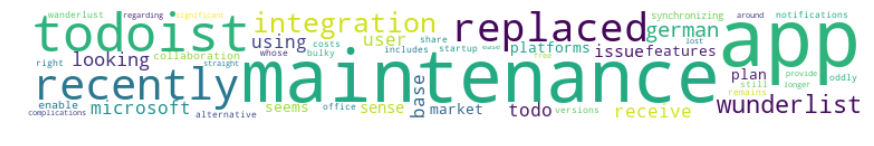

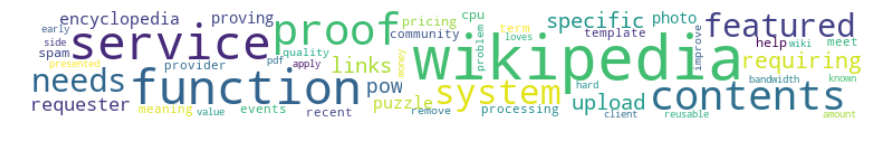

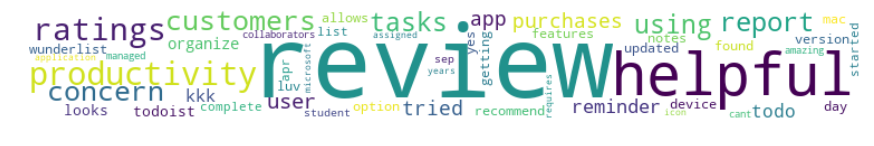

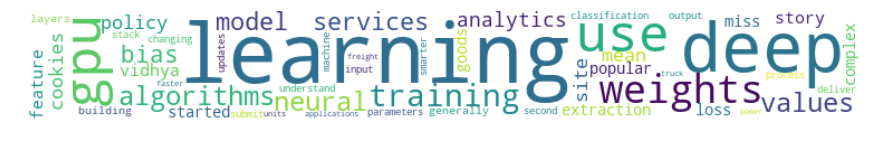

PARTICIPANT:  P02
--------------------------



KeyboardInterrupt: 

In [15]:
for participant in participants:
    print("PARTICIPANT: ", participant)
    print("--------------------------")
    print()
    index = 0
    
    n_words = []
    
    tasks = te.get_tasks_for_participant(path_to_data, participant, ungrouped=True, using_tfidf=True)
    if not os.path.exists(f"../wordclouds/task segments weighted/{participant}"):
        os.mkdir(f"../wordclouds/task segments weighted/{participant}")
    for task, order in zip(tasks[0], tasks[1]):
        n_words.append(len(task.keys()))
        #print(len(task.keys()))
        #print(order, task.most_common(10))
        wc = WordCloud(background_color="white", max_words=50, width=750, height=100)
        wc.generate_from_frequencies(task)
        plt.figure(figsize=(15,10))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.savefig("test.png", bbox_inches='tight')
        #plt.savefig(f'../wordclouds/task segments weighted/{participant}/wc{index}_label_{order}.png', bbox_inches='tight')
        plt.show()


In [10]:
np.mean(n_words)

1148.111111111111